План занятия
1. Загрузить массив данных зависимости твердости стали от ее химического состава, времени и температуры отпуска;
2. Оценить влияние каждого из признаков на изменение твердости;
3. Разбить данные на данные для обучения и данные для проверки качества модели;
4. Получить уравнение линейной регрессии на основе данных для обучения;
5. Оценить качество модели на основе данных для проверки по коэффициенту детерминации.

In [1]:
# Импортируем нужные нам библиотеки
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Путь к файлу, в котором хранятся данные по твердости в зависимости от хим. состава и параметров отпуска
filepath = '../data/tempering_data.txt'
# Посмотрим что в этом файле есть (выведем в консоль первые 7 его строк):
with open(filepath, 'r') as f:
    pure_data = f.readlines()
for i in range (0, 7):
    print (pure_data[i])

Time(sec)    Temperature(C)    C(%wt)    Mn(%wt)    P(%wt)    S(%wt)    Si(%wt)    Ni(%wt)    Cr(%wt)    Mo(%wt)    V(%wt)    Al(%wt)    Cu(%wt)    HRC    

600    204.4    0.25    0.79    0.012    0.026    0.11    0    0    0    0    0    0    50.6

600    260    0.25    0.79    0.012    0.026    0.11    0    0    0    0    0    0    48.3

600    315.6    0.25    0.79    0.012    0.026    0.11    0    0    0    0    0    0    43.7

600    371.1    0.25    0.79    0.012    0.026    0.11    0    0    0    0    0    0    40.5

600    426.7    0.25    0.79    0.012    0.026    0.11    0    0    0    0    0    0    37.3

600    482.2    0.25    0.79    0.012    0.026    0.11    0    0    0    0    0    0    31.2



In [3]:
# Нам нужно, на всякий случай, иметь под рукой переменную с именами колонок:
column_names = pure_data[0].split()  # выбираем первую строки и разбиваем на слова (названия колонок)
# смотрим, что получилось
column_names

['Time(sec)',
 'Temperature(C)',
 'C(%wt)',
 'Mn(%wt)',
 'P(%wt)',
 'S(%wt)',
 'Si(%wt)',
 'Ni(%wt)',
 'Cr(%wt)',
 'Mo(%wt)',
 'V(%wt)',
 'Al(%wt)',
 'Cu(%wt)',
 'HRC']

In [4]:
# Теперь преобразуем данные в массив NumPy
data = [] # пустой список, куда будем копировать данные из списка pure_data построчно, предварительно 
            # их разделив и преобразовав из текстовых в числовые (типа float)
for line in pure_data[1:]:  # пропускаем заголовок
    line = line.strip() # убираем все "пробельные" символы с концов строки — то есть в начале и в конце, но не посередине.
    if line:  # если строка не пустая
        row = [float(x) for x in line.split()] #  разбиваем строку на части и возвращает ее в виде списка
        data.append(row) # записываем список row в список data
data = np.array(data) # преобразовываем список data в массив NumPy
# перемешиваем строки в массиве данных, что-бы исключить упорядоченность
np.random.seed(42) # устанавливаем фиксированный случайный набор для разбиения (что бы результаты у нас были повторяемыми)
np.random.shuffle(data) # перемешиваем строки
print (data[0:2, :])

[[7.920e+04 4.822e+02 4.100e-01 5.700e-01 1.700e-02 5.000e-03 2.400e-01
  1.700e-01 1.570e+00 3.600e-01 0.000e+00 1.260e+00 0.000e+00 4.360e+01]
 [3.600e+03 5.933e+02 4.400e-01 7.900e-01 2.000e-02 3.000e-02 2.400e-01
  2.000e-02 2.000e-02 1.000e-02 0.000e+00 0.000e+00 0.000e+00 2.470e+01]]


In [5]:
# Нам нужно разбить массив data на массив с признаками и вектор целевой переменной (твердость после закалки)
# Обозначим массив с признаками через X, а вектор целевой перменнной через y
X = data[:, :-1]
y = data[:, -1]
# Посмотрим, что получилось
print (X[:5])

[[7.920e+04 4.822e+02 4.100e-01 5.700e-01 1.700e-02 5.000e-03 2.400e-01
  1.700e-01 1.570e+00 3.600e-01 0.000e+00 1.260e+00 0.000e+00]
 [3.600e+03 5.933e+02 4.400e-01 7.900e-01 2.000e-02 3.000e-02 2.400e-01
  2.000e-02 2.000e-02 1.000e-02 0.000e+00 0.000e+00 0.000e+00]
 [9.000e+02 4.000e+02 3.100e-01 5.200e-01 7.000e-03 2.600e-02 1.000e-01
  0.000e+00 1.500e-02 0.000e+00 0.000e+00 0.000e+00 6.000e-02]
 [1.440e+04 7.044e+02 3.100e-01 5.700e-01 8.000e-03 2.500e-02 9.000e-02
  2.000e-02 2.000e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.600e+03 3.711e+02 4.500e-01 7.300e-01 1.700e-02 3.000e-02 1.700e-01
  1.000e-02 2.000e-02 1.000e-02 0.000e+00 0.000e+00 0.000e+00]]


<h3 align="center">Коэффициент корреляции Пирсона</h3>

**Коэффициент корреляции Пирсона** — это статистическая мера, которая оценивает силу и направление линейной связи между двумя количественными переменными. Он обозначается как $ r $ и принимает значения в диапазоне от $-1$ до $1$:

- $ r = 1 $: полная положительная линейная корреляция (при увеличении одной переменной другая также увеличивается).
- $ r = 0 $: отсутствие линейной корреляции.
- $ r = -1 $: полная отрицательная линейная корреляция (при увеличении одной переменной другая уменьшается).

#### Формула:
$$
\begin{flalign}
& r = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2} \sum{(y_i - \bar{y})^2}}} &&
\end{flalign}
$$

где:
- $ x_i, y_i $ — значения переменных,
- $ \bar{x}, \bar{y} $ — средние значения переменных.


#### Интерпретация:
- $ |r| \geq 0.7 $: сильная корреляция,
- $ 0.3 \leq |r| < 0.7 $: умеренная корреляция,
- $ |r| < 0.3 $: слабая корреляция.

In [6]:
# Оценим влияние того или иного признака из имеющейся выборки на твердость с помощью коэффициента Пирсона
correlations = []
for i in range(X.shape[1]):
    corr = np.corrcoef(X[:, i], y)[0, 1]  # корреляция между i-м признаком и y
    correlations.append(corr)

# Посмотрим на результаты: чем выше модуль числа, тем более значимым является признак
for name, corr in zip(column_names[:-1], correlations):
    print(f"{name}: {corr:.3f}")
# Близко к 1 → сильная положительная связь,
# Близко к -1 → сильная отрицательная связь,
# Близко к 0 → нет линейной связи.

Time(sec): -0.180
Temperature(C): -0.869
C(%wt): 0.367
Mn(%wt): -0.131
P(%wt): -0.012
S(%wt): -0.178
Si(%wt): 0.074
Ni(%wt): -0.091
Cr(%wt): 0.184
Mo(%wt): -0.021
V(%wt): 0.002
Al(%wt): 0.027
Cu(%wt): 0.113


In [7]:
# Переведем массив X в кодированный масштаб (от 0 до 1, где 0 - минимально возможное значение признака, а 1 - максимально возможное)
X_scaled = (X - X.min(axis = 0))/(X.max(axis = 0) - X.min(axis = 0))
# нужно добавить в начало столбец с 1 для расчета свобобного члена:
X_scaled = np.concatenate([np.ones((X_scaled.shape[0], 1)), X_scaled], axis=1)

In [8]:
# Далее нам нужно разбить данные на данные для обучения и данные для проверки получившейся модели
splitting_point = int(y.shape[0]*0.8) # предполагаем, что 80% данных мы пустим на обучение и 20% на проверку резульатов
X_train, X_test = X_scaled[:splitting_point, :], X_scaled[splitting_point:, :]
y_train, y_test = y[:splitting_point], y[splitting_point:]

<h3 align="center">Линейная регрессия и расчёт коэффициентов</h3>

**Линейная регрессия** — это метод моделирования линейной зависимости между зависимой переменной $ y $ и одной или несколькими независимыми переменными $ X $. Цель — найти такую гиперплоскость, которая наилучшим образом описывает значения $ y $ с минимальной ошибкой (обычно по методу наименьших квадратов).

#### Модель:
$$
\begin{flalign}
& y = X\phi + \varepsilon &&
\end{flalign}
$$

где:
- $ y \in \mathbb{R}^n $ — вектор целевой переменной (в нашем случае это твердость после отпуска),
- $ X \in \mathbb{R}^{n \times p} $ — матрица признаков со столбцом единиц для свободного члена (в нашем случае это время и температура отпуска и хим. состав),
- $ \phi \in \mathbb{R}^p $ — вектор коэффициентов (параметров модели),
- $ \varepsilon $ — вектор ошибок.

#### Решение методом наименьших квадратов:
Задача сводится к минимизации суммы квадратов остатков:
$$
\begin{flalign}
\min_\beta \| y - X\beta \|^2 &&
\end{flalign}
$$
Аналитическое решение (нормальное уравнение):
$$
\begin{flalign}
& \hat{\beta} = (X^T X)^{-1} X^T y &&
\end{flalign}
$$

Это выражение получено с помощью дифференцирования функции потерь по $ \beta $ и приравнивания производной к нулю.

In [9]:
# коэффициенты линейного уравнения определяются аналитически по формуле (потом добавлю)
phi = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
phi

array([ 55.83871063,  -8.72705299, -41.41973267,  14.41676144,
         4.37001322,   4.48622775,  -1.48206071,   8.64816234,
         2.19259858,   4.83927734,   3.5758514 ,   4.02553142,
         0.14080941,   0.95414122])

In [10]:
# расчитаем модельные значения
y_train_model =X_train@phi
y_test_model =X_test@phi
# Расчитаем коэффициент детерминации (R²) для тестовой выборки
ss_res = np.sum((y_test - y_test_model) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

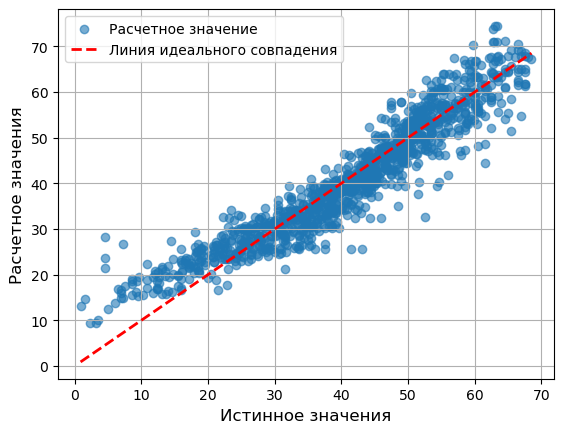

In [11]:
plt.scatter(y_train, y_train_model, alpha=0.6, label='Расчетное значение')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', lw=2, label='Линия идеального совпадения')
plt.xlabel('Истинное значения', fontsize=12)
plt.ylabel('Расчетное значения', fontsize=12)
plt.grid(True)
plt.legend()

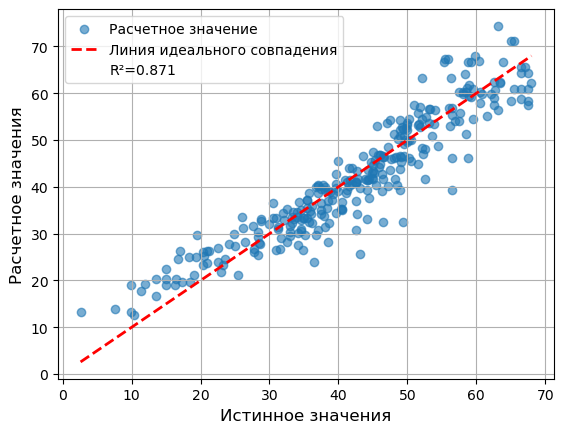

In [12]:
plt.scatter(y_test, y_test_model, alpha=0.6, label='Расчетное значение')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Линия идеального совпадения')
plt.plot([], [], ' ', label=f'R²={round(r2, 3)}')
plt.xlabel('Истинное значения', fontsize=12)
plt.ylabel('Расчетное значения', fontsize=12)
plt.grid(True)
plt.legend()